# Platform Engagement and Growth Analytics

## Stakeholder Questions:
1. What factors are driving or limiting user growth?
2. How do engagement patterns differ by content type or user segment?
3. Which campaigns or acquisition channels bring the most engaged, retained users?
4. How can we maximize ARPU and minimize churn?
5. What content or genres drive the most engagement and repeat sessions?


## Data Setup

In [9]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)
plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

con=duckdb.connect()

con.execute("""
CREATE TABLE users_raw AS SELECT * FROM read_csv_auto('data/users.csv');
CREATE TABLE sessions_raw AS SELECT * FROM read_csv_auto('data/sessions.csv');
""")

In [10]:
print("\nSample data from each table:")
print("================================")
print("Users Table:")
print(f"\n{con.execute("SELECT * FROM users_raw LIMIT 5").fetchdf()}")
print("================================")
print("Sessions Table:")
print(f"\n{con.execute("SELECT * FROM sessions_raw LIMIT 5").fetchdf()}")


Sample data from each table:
Users Table:

  user_id signup_date cancel_date       region plan_type  price_usd  \
0  U00001  2024-05-11         NaT         APAC     BASIC       8.99   
1  U00002  2023-03-28         NaT        LATAM     Basic      10.99   
2  U00003  2023-01-20  2024-05-19  Europe/MENA  Standard      14.99   
3  U00004  2024-07-29         NaT        LatAm  Standard      14.99   
4  U00005  2023-08-02         NaT        LATAM  Standard      13.99   

  acquisition_channel  
0            referral  
1             Organic  
2             organic  
3            Referral  
4            referral  
Sessions Table:

  session_id user_id       date   device  duration_min content_type  \
0   S0000001  U01743 2024-04-22   Tablet         29.65        Movie   
1   S0000002  U01804 2023-01-05   Tablet          8.84       Series   
2   S0000003  U01712 2024-12-04   Tablet          0.00       Shorts   
3   S0000004  U01204 2023-03-03  Desktop         47.17       Shorts   
4   S0000005 

## Data Cleaning

### User Table

#### Checking for issues

In [11]:
print(con.execute("SELECT * FROM users_raw").fetchdf().info())
print(con.execute("SELECT * FROM users_raw LIMIT 5").fetchdf())

print("region values:")
print(con.execute("SELECT region, COUNT(region) FROM users_raw GROUP BY region").fetchdf())

print("plan_type values:")
print(con.execute("SELECT plan_type, COUNT(plan_type) FROM users_raw GROUP BY plan_type").fetchdf())

print("price_usd values:")
print(con.execute("SELECT price_usd, COUNT(price_usd) FROM users_raw GROUP BY price_usd").fetchdf())

print("Acquisition channel values:")
print(con.execute("SELECT acquisition_channel, COUNT(acquisition_channel) FROM users_raw GROUP BY acquisition_channel").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(region IS NULL) AS null_region,
       COUNTIF(plan_type IS NULL) AS null_plan_type,
       COUNTIF(price_usd IS NULL) AS null_price,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(signup_date IS NULL) AS null_signup_date,
       COUNTIF(acquisition_channel IS NULL) AS null_acquisition_channel,
       COUNTIF(cancel_date IS NULL) AS null_cancel_date
FROM users_raw;
""").fetchdf())

print("Cancel date before signup date:")
print(con.execute("""
SELECT *
FROM users_raw
WHERE cancel_date < signup_date;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              2060 non-null   object        
 1   signup_date          2060 non-null   datetime64[us]
 2   cancel_date          586 non-null    datetime64[us]
 3   region               1992 non-null   object        
 4   plan_type            2015 non-null   object        
 5   price_usd            2037 non-null   float64       
 6   acquisition_channel  2060 non-null   object        
dtypes: datetime64[us](2), float64(1), object(4)
memory usage: 112.8+ KB
None
  user_id signup_date cancel_date       region plan_type  price_usd  \
0  U00001  2024-05-11         NaT         APAC     BASIC       8.99   
1  U00002  2023-03-28         NaT        LATAM     Basic      10.99   
2  U00003  2023-01-20  2024-05-19  Europe/MENA  Standard      14.99   
3  U00004  2024-07-

#### Clean and validate, export to pandas dataframe

In [12]:
con.execute("""
CREATE OR REPLACE TABLE users_clean AS
WITH ranked AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY signup_date DESC, cancel_date NULLS LAST) AS rn
  FROM users_raw
)
SELECT
  user_id,
  CAST(signup_date AS DATE) AS signup_date,
  CASE 
    WHEN TRY_CAST(cancel_date AS DATE) IS NULL THEN NULL
    WHEN TRY_CAST(cancel_date AS DATE) < TRY_CAST(signup_date AS DATE) THEN NULL  -- fix bad ordering
    ELSE CAST(cancel_date AS DATE)
  END AS cancel_date,
  CASE
    WHEN LOWER(region) IN ('na','n. america','north america') THEN 'North America'
    WHEN LOWER(region) LIKE '%lat%' THEN 'LATAM'
    WHEN LOWER(region) LIKE '%emea%' OR LOWER(region) LIKE '%europe%' THEN 'EMEA'
    WHEN LOWER(region) LIKE '%apac%' OR LOWER(region) LIKE '%asia%' THEN 'APAC'
    ELSE COALESCE(NULLIF(TRIM(region),''), 'Unknown')
  END AS region,
  CASE
    WHEN LOWER(plan_type) LIKE '%b%' THEN 'Basic'
    WHEN LOWER(plan_type) LIKE '%st%' THEN 'Standard'
    WHEN LOWER(plan_type) LIKE '%an%' THEN 'Standard'
    WHEN LOWER(plan_type) LIKE 'p%' THEN 'Premium'
    ELSE LOWER(plan_type)
  END AS plan_type,
  TRY_CAST(price_usd AS DOUBLE) AS price_usd,
  CASE
    WHEN LOWER(acquisition_channel) LIKE '%ic%' THEN 'Organic'
    WHEN LOWER(acquisition_channel) LIKE '%or%' THEN 'Organic'
    WHEN LOWER(acquisition_channel) LIKE '%soc%' THEN 'Paid Social'
    WHEN LOWER(acquisition_channel) LIKE '%ia%' THEN 'Paid Social'
    WHEN LOWER(acquisition_channel) LIKE '%ref%' THEN 'Referral'
    WHEN LOWER(acquisition_channel) LIKE '%err%' THEN 'Referral'
    WHEN LOWER(acquisition_channel) LIKE '%ch%' THEN 'Paid Search'
    WHEN LOWER(acquisition_channel) LIKE '%par%' THEN 'Partnership'
    WHEN LOWER(acquisition_channel) LIKE '%ner%' THEN 'Partnership'
    ELSE acquisition_channel
  END AS acquisition_channel
FROM ranked
WHERE rn = 1
  AND user_id IS NOT NULL
;
""")

print(con.execute("DESCRIBE users_clean").fetchdf())

print("region values:")
print(con.execute("SELECT region, COUNT(region) FROM users_clean GROUP BY region").fetchdf())

print("plan_type values:")
print(con.execute("SELECT plan_type, COUNT(plan_type) FROM users_clean GROUP BY plan_type").fetchdf())

print("price_usd values:")
print(con.execute("SELECT price_usd, COUNT(price_usd) FROM users_clean GROUP BY price_usd").fetchdf())

print("Acquisition channel values:")
print(con.execute("SELECT acquisition_channel, COUNT(acquisition_channel) FROM users_clean GROUP BY acquisition_channel").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(region IS NULL) AS null_region,
       COUNTIF(plan_type IS NULL) AS null_plan_type,
       COUNTIF(price_usd IS NULL) AS null_price,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(signup_date IS NULL) AS null_signup_date,
       COUNTIF(acquisition_channel IS NULL) AS null_acquisition_channel,
       COUNTIF(cancel_date IS NULL) AS null_cancel_date
FROM users_clean;
""").fetchdf())

print("Cancel date before signup date:")
print(con.execute("""
SELECT *
FROM users_clean
WHERE cancel_date < signup_date;
""").fetchdf())

users = con.execute("""SELECT * FROM users_clean""").fetch_df()

           column_name column_type null   key default extra
0              user_id     VARCHAR  YES  None    None  None
1          signup_date        DATE  YES  None    None  None
2          cancel_date        DATE  YES  None    None  None
3               region     VARCHAR  YES  None    None  None
4            plan_type     VARCHAR  YES  None    None  None
5            price_usd      DOUBLE  YES  None    None  None
6  acquisition_channel     VARCHAR  YES  None    None  None
region values:
          region  count(region)
0          LATAM            498
1           EMEA            491
2        Unknown             65
3  North America            463
4           APAC            483
plan_type values:
  plan_type  count(plan_type)
0      None                 0
1   Premium               635
2     Basic               628
3  Standard               694
price_usd values:
    price_usd  count(price_usd)
0       13.99               409
1       16.99               127
2        8.99               115

#### Looking for outliers

  user_id signup_date cancel_date         region plan_type  price_usd  \
0  U00047  2023-09-19         NaT  North America   Premium      17.99   
1  U00058  2024-07-20         NaT  North America     Basic       8.99   
2  U00068  2024-04-25         NaT          LATAM   Premium      18.99   
3  U00080  2023-03-03         NaT  North America     Basic       9.99   
4  U00099  2024-05-08         NaT  North America  Standard      14.99   

  acquisition_channel  
0            Referral  
1         Paid Search  
2         Partnership  
3             Organic  
4         Paid Search  


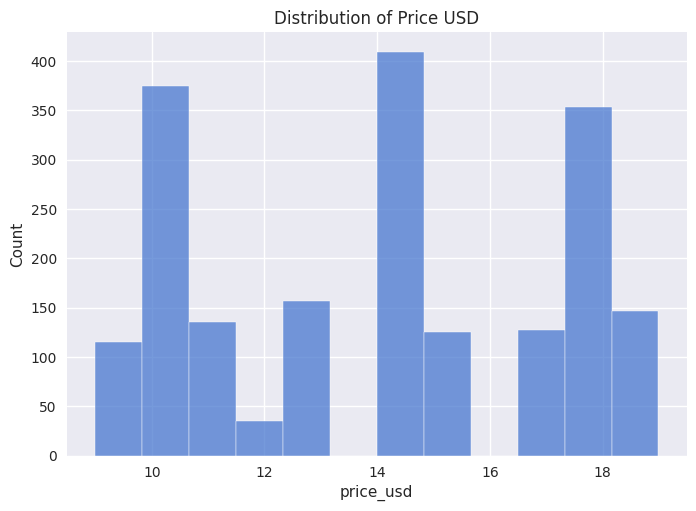

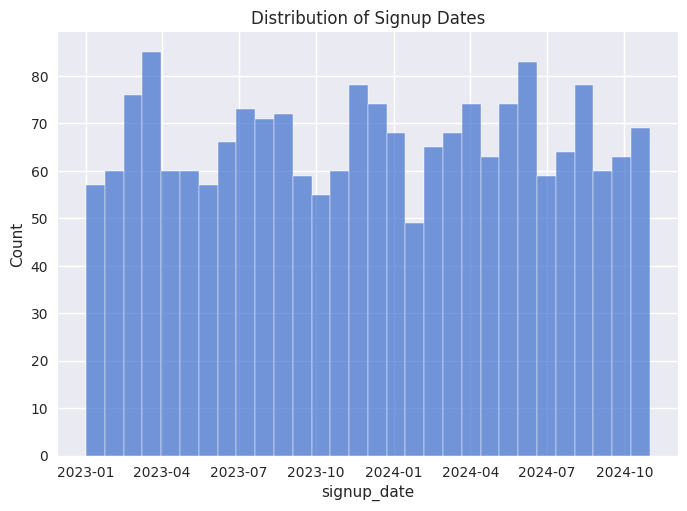

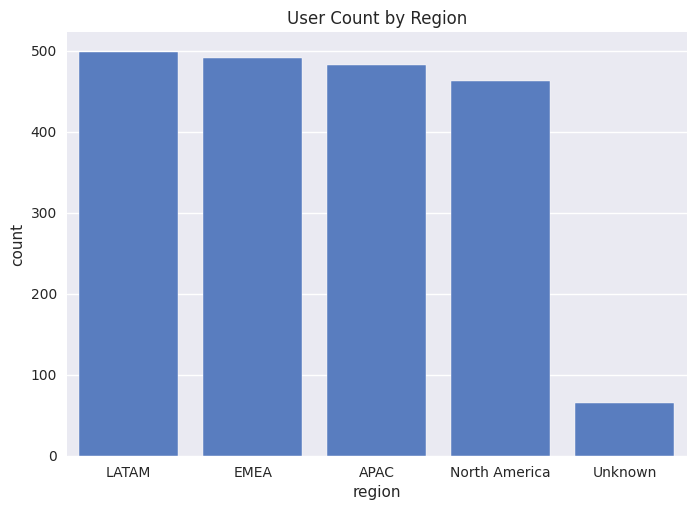

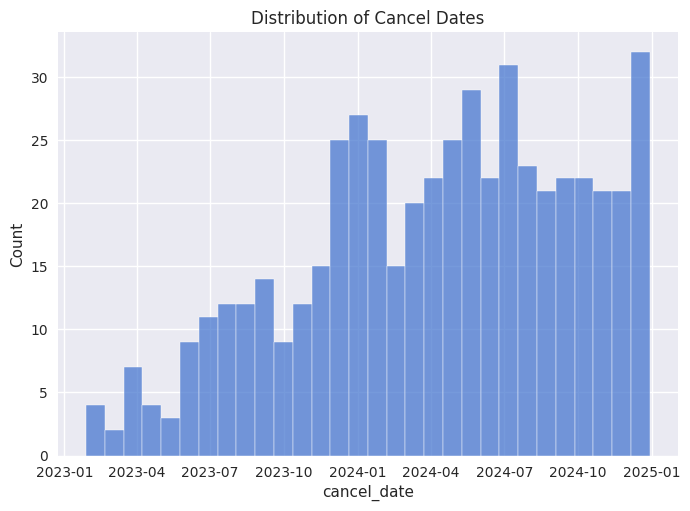

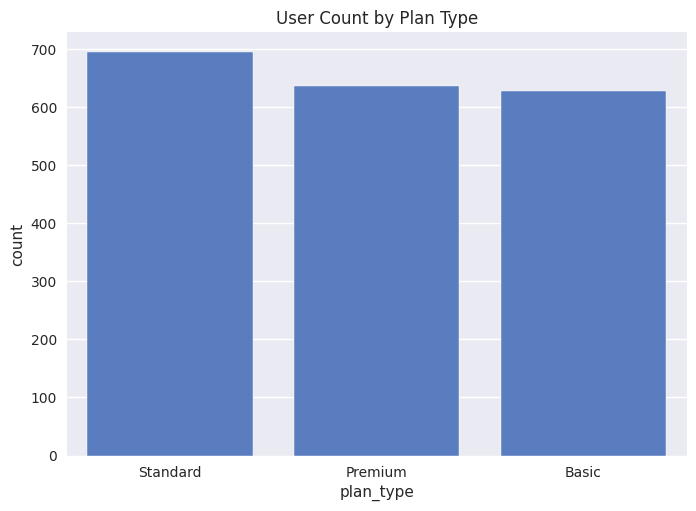

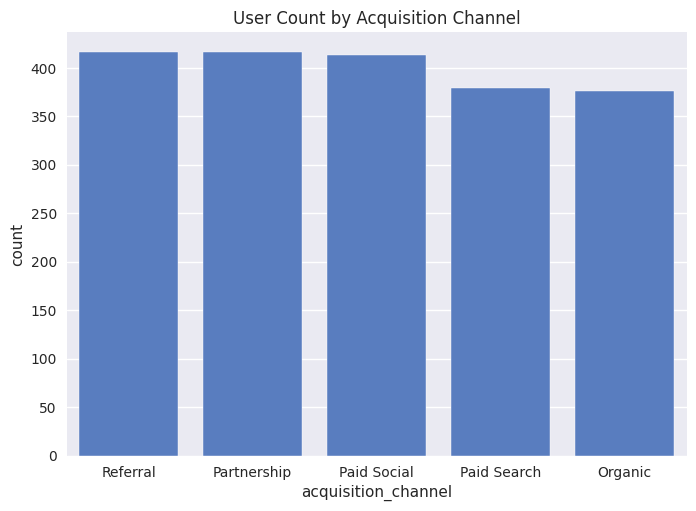

In [18]:
print(users.head())

sns.histplot(users, x='price_usd')
plt.title('Distribution of Price USD')
plt.show()

sns.histplot(users, x='signup_date', bins=30)
plt.title('Distribution of Signup Dates')
plt.show()

sns.countplot(data=users, x='region', order=users['region'].value_counts().index)
plt.title('User Count by Region')
plt.show()

sns.histplot(users, x='cancel_date', bins=30)
plt.title('Distribution of Cancel Dates')
plt.show()

sns.countplot(data=users, x='plan_type', order=users['plan_type'].value_counts().index)
plt.title('User Count by Plan Type')
plt.show()

sns.countplot(data=users, x='acquisition_channel', order=users['acquisition_channel'].value_counts().index)
plt.title('User Count by Acquisition Channel')
plt.show()

### Sessions Table

#### Standardize Columns

In [14]:
print(con.execute("SELECT * FROM sessions_raw").fetchdf().info())

print("\nSample values:")
print(con.execute("SELECT * FROM sessions_raw LIMIT 5").fetchdf())

print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration_min, watch_completion_pct FROM sessions_raw").fetchdf().describe())

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_raw;
""").fetchdf())

print("\nDevice values:")
print(con.execute("SELECT device, COUNT(device) from sessions_raw GROUP BY device").fetchdf())

print("\nContent Type values:")
print(con.execute("SELECT content_type, COUNT(content_type) from sessions_raw GROUP BY content_type").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration_min IS NULL) AS null_duration_min,
       COUNTIF(watch_completion_pct IS NULL) AS null_watch_completion_pct,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(content_type IS NULL) AS null_content_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date
FROM sessions_raw;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session_id            51000 non-null  object        
 1   user_id               51000 non-null  object        
 2   date                  51000 non-null  datetime64[us]
 3   device                50457 non-null  object        
 4   duration_min          50491 non-null  float64       
 5   content_type          51000 non-null  object        
 6   content_id            51000 non-null  object        
 7   watch_completion_pct  50506 non-null  float64       
dtypes: datetime64[us](1), float64(2), object(5)
memory usage: 3.1+ MB
None

Sample values:
  session_id user_id       date   device  duration_min content_type  \
0   S0000001  U01743 2024-04-22   Tablet         29.65        Movie   
1   S0000002  U01804 2023-01-05   Tablet          8.84       Series   
2   S00

In [15]:
con.execute("""
CREATE OR REPLACE TABLE sessions_clean AS
  SELECT
    session_id,
    CAST(date AS DATE) AS date,
    CASE 
      WHEN TRY_CAST(duration_min AS DOUBLE) IS NULL OR TRY_CAST(duration_min AS DOUBLE) < 0 THEN NULL
      ELSE TRY_CAST(duration_min AS DOUBLE)
    END AS duration_min,
    CASE 
      WHEN TRY_CAST(watch_completion_pct AS DOUBLE) IS NULL OR TRY_CAST(watch_completion_pct AS DOUBLE) < 0 OR TRY_CAST(watch_completion_pct AS DOUBLE) > 100 THEN NULL
      ELSE TRY_CAST(watch_completion_pct AS DOUBLE)
    END AS watch_completion_pct,
    CASE
      WHEN LOWER(device) LIKE '%mo%' THEN 'Mobile'
      WHEN LOWER(device) LIKE '%bil%' THEN 'Mobile'
      WHEN LOWER(device) LIKE '%tab%' THEN 'Tablet'
      WHEN LOWER(device) LIKE '%let%' THEN 'Tablet'
      WHEN LOWER(device) LIKE '%desk%' THEN 'Desktop'
      WHEN LOWER(device) LIKE '%top%' THEN 'Desktop'
      WHEN LOWER(device) LIKE '%tv%' THEN 'TV'
      ELSE device
    END AS device,
    CASE
      WHEN LOWER(content_type) LIKE '%vid%' THEN 'Video'
      WHEN LOWER(content_type) LIKE '%art%' THEN 'Article'
      WHEN LOWER(content_type) LIKE '%pod%' THEN 'Podcast'
      ELSE content_type
    END AS content_type,
    user_id
  FROM sessions_raw
  WHERE session_id IS NOT NULL
""")

print(con.execute("SELECT * FROM sessions_clean").fetchdf().info())

print("\nSample values:")
print(con.execute("SELECT * FROM sessions_clean LIMIT 5").fetchdf())

print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration_min, watch_completion_pct FROM sessions_clean").fetchdf().describe())

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_clean;
""").fetchdf())

print("\nDevice values:")
print(con.execute("SELECT device, COUNT(device) from sessions_clean GROUP BY device").fetchdf())

print("\nContent Type values:")
print(con.execute("SELECT content_type, COUNT(content_type) from sessions_clean GROUP BY content_type").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration_min IS NULL) AS null_duration_min,
       COUNTIF(watch_completion_pct IS NULL) AS null_watch_completion_pct,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(content_type IS NULL) AS null_content_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date
FROM sessions_clean;
""").fetchdf())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   session_id            51000 non-null  object        
 1   date                  51000 non-null  datetime64[us]
 2   duration_min          50129 non-null  float64       
 3   watch_completion_pct  45572 non-null  float64       
 4   device                50457 non-null  object        
 5   content_type          51000 non-null  object        
 6   user_id               51000 non-null  object        
dtypes: datetime64[us](1), float64(2), object(4)
memory usage: 2.7+ MB
None

Sample values:
  session_id       date  duration_min  watch_completion_pct   device  \
0   S0000001 2024-04-22         29.65                  37.6   Tablet   
1   S0000002 2023-01-05          8.84                  75.0   Tablet   
2   S0000003 2024-12-04          0.00                  90.4   

#### Dedup

In [19]:
con.execute("""
CREATE OR REPLACE TABLE sessions_clean AS
WITH ranked AS (
SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY user_id, date, duration_min, watch_completion_pct, device, content_type NULLS LAST) AS rn
FROM sessions_clean
)
SELECT
    session_id,
    date,
    duration_min,
    watch_completion_pct,
    device,
    content_type,
    user_id
FROM ranked
WHERE rn = 1
""")

print("\nSession ID Distinct Count:")
print(con.execute("""
SELECT COUNT(DISTINCT session_id) AS distinct_session_ids,
       COUNT(session_id) AS total_session_ids
FROM sessions_clean;
""").fetchdf())

print("\nRemaining Duplicate Rows:")
print(con.execute("""
WITH duplicate_sessions AS (
SELECT session_id
FROM sessions_clean
GROUP BY session_id
HAVING COUNT(*) > 1
)
SELECT
                  date,
                  duration_min,
                  watch_completion_pct,
                  device,
                  content_type
FROM sessions_clean
WHERE session_id IN (SELECT session_id FROM duplicate_sessions)
ORDER BY session_id, user_id, date, duration_min, watch_completion_pct, device, content_type NULLS LAST
""").fetchdf())

print("\nNull Values:")
print(con.execute("""
SELECT COUNT(*) AS total_rows,
       COUNTIF(duration_min IS NULL) AS null_duration_min,
       COUNTIF(watch_completion_pct IS NULL) AS null_watch_completion_pct,
       COUNTIF(device IS NULL) AS null_device,
       COUNTIF(content_type IS NULL) AS null_content_type,
       COUNTIF(user_id IS NULL) AS null_user_id,
       COUNTIF(date IS NULL) AS null_date
FROM sessions_clean;
""").fetchdf())
print("\nSession Quantitative Data Statistics:")
print(con.execute("SELECT date, duration_min, watch_completion_pct FROM sessions_clean").fetchdf().describe())
print("\nSample values:")

sessions = con.execute("""SELECT * FROM sessions_clean""").fetch_df()
sessions.head()


Session ID Distinct Count:
   distinct_session_ids  total_session_ids
0                 50000              50000

Remaining Duplicate Rows:
Empty DataFrame
Columns: [date, duration_min, watch_completion_pct, device, content_type]
Index: []

Null Values:
   total_rows  null_duration_min  null_watch_completion_pct  null_device  \
0       50000              839.0                     5306.0        516.0   

   null_content_type  null_user_id  null_date  
0                0.0           0.0        0.0  

Session Quantitative Data Statistics:
                             date  duration_min  watch_completion_pct
count                       50000  49161.000000          44694.000000
mean   2023-12-30 23:57:00.288000     48.910603             61.382051
min           2023-01-01 00:00:00      0.000000              0.000000
25%           2023-07-01 00:00:00     17.690000             46.900000
50%           2023-12-31 00:00:00     35.120000             62.800000
75%           2024-06-30 00:00:00    

,session_id,date,duration_min,watch_completion_pct,device,content_type,user_id
0,S0000011,2024-07-18,0.00,97.3,TV,Shorts,U01246
1,S0000018,2023-07-04,27.82,47.6,Tablet,Movie,U01405
2,S0000036,2024-02-05,29.59,77.5,TV,Shorts,U01038
3,S0000072,2024-09-04,38.96,49.7,TV,Movie,U00637
4,S0000087,2023-09-20,NaN,NaN,None,Movie,U01242


#### Finding Outliers

  session_id       date  duration_min  watch_completion_pct  device  \
0   S0000011 2024-07-18          0.00                  97.3      TV   
1   S0000018 2023-07-04         27.82                  47.6  Tablet   
2   S0000036 2024-02-05         29.59                  77.5      TV   
3   S0000072 2024-09-04         38.96                  49.7      TV   
4   S0000087 2023-09-20           NaN                   NaN    None   

  content_type user_id  
0       Shorts  U01246  
1        Movie  U01405  
2       Shorts  U01038  
3        Movie  U00637  
4        Movie  U01242  


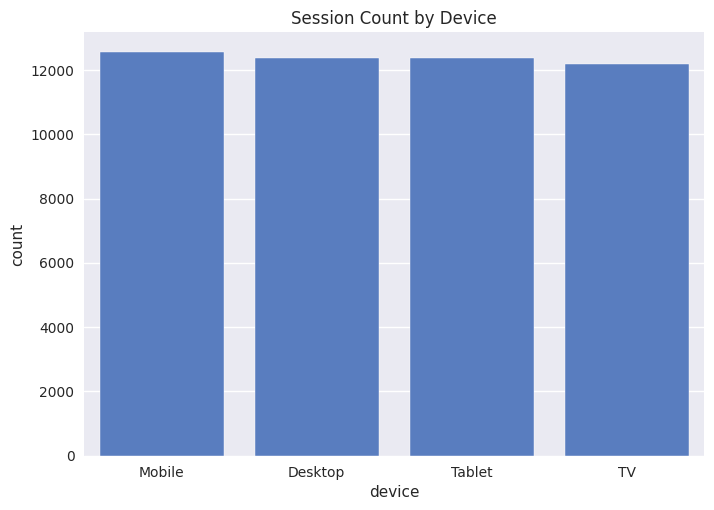

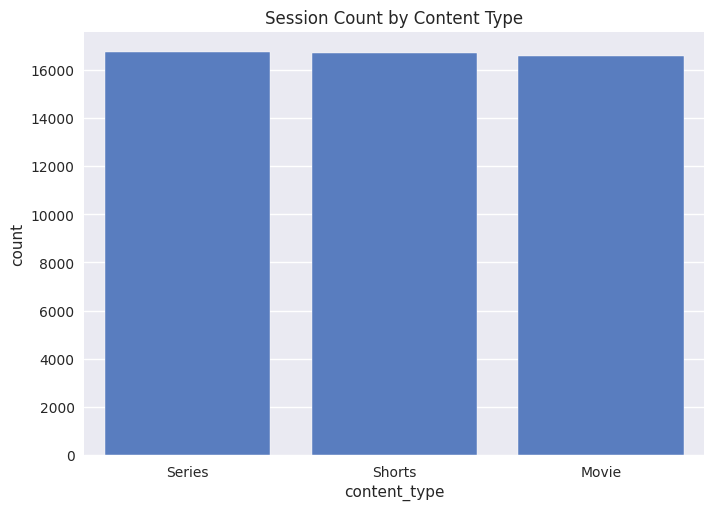

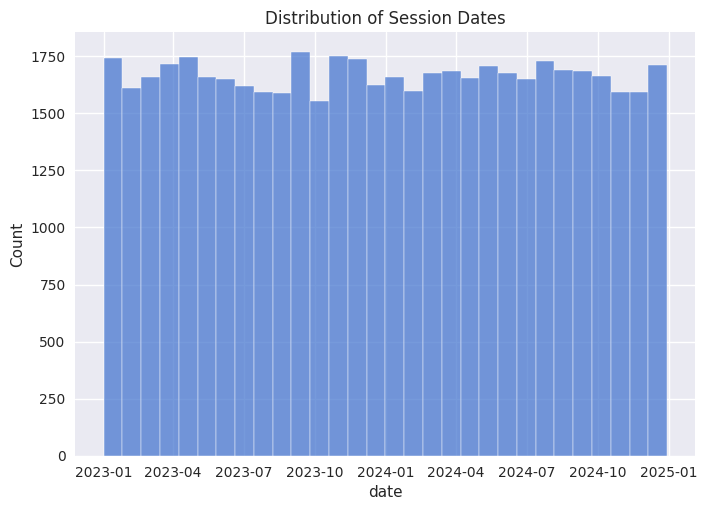

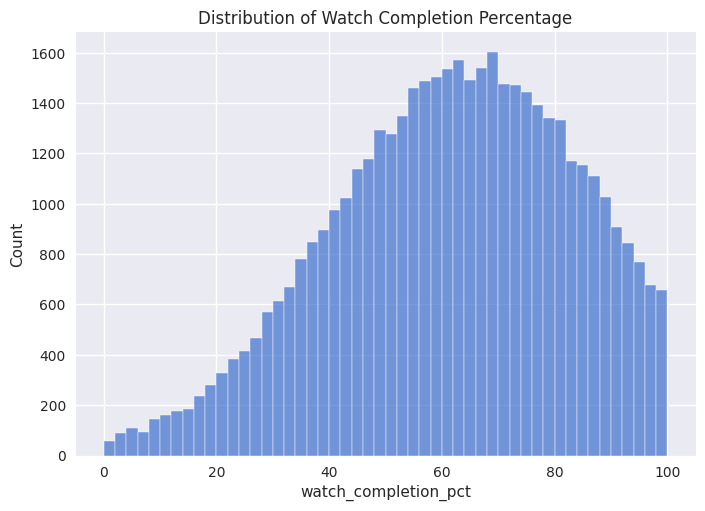

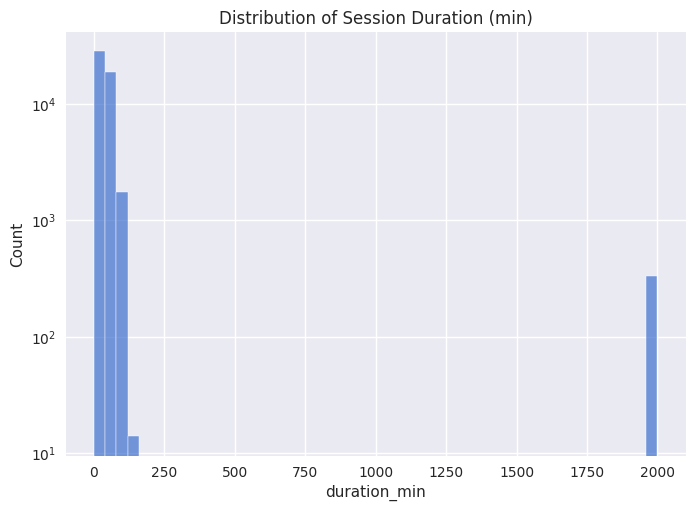

In [31]:
print(sessions.head())

sns.countplot(data=sessions, x='device', order=sessions['device'].value_counts().index)
plt.title('Session Count by Device')
plt.show()

sns.countplot(data=sessions, x='content_type', order=sessions['content_type'].value_counts().index)
plt.title('Session Count by Content Type')
plt.show()

sns.histplot(sessions, x='date', bins=30)
plt.title('Distribution of Session Dates')
plt.show()

sns.histplot(sessions, x='watch_completion_pct', bins=50)
plt.title('Distribution of Watch Completion Percentage')
plt.show()

sns.histplot(sessions, x='duration_min', bins=50)
plt.title('Distribution of Session Duration (min)')
plt.yscale('log')
plt.show()

## EDA

### Metrics

| KPI                                       | Derived From         | Formula / Logic                               | Universally Applicable Insight    |
| ----------------------------------------- | -------------------- | --------------------------------------------- | --------------------------------- |
| **DAU / MAU**                             | Sessions             | Count distinct users per day/month            | Engagement intensity              |
| **Engagement Rate**                       | Sessions             | Sessions per active user per day              | How “sticky” product is           |
| **Average Watch Time / Session Duration** | Sessions             | Avg(duration_min)                             | Session quality                   |
| **Completion Rate**                       | Sessions             | Avg(watch_completion_pct)                     | Content relevance or satisfaction |
| **Retention Rate**                        | Users                | (Returning users at t+30 / users active at t) | User loyalty                      |
| **Churn Rate**                            | Users                | 1 – retention                                 | Attrition analysis                |
| **Subscriber Growth Rate**                | Users                | (New subs – churned subs) / prior subs        | Growth health                     |
| **ARPU (Average Revenue per User)**       | Revenue              | Total revenue / active users                  | Monetization efficiency           |
| **Ad CPM**                                | Marketing + Revenue  | ad_revenue_usd / (impressions/1000)           | Ad efficiency                     |
| **Engagement per $ Spent**                | Marketing + Sessions | active_users / spend_usd                      | Marketing ROI                     |